In [2]:
from dtw import dtw
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline
from osgeo import gdal
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import time as t
import math

In [153]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [154]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [155]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [156]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [157]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        print ind
        print min_dist
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [158]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        #print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[ind]
    
        #recalculate centroids of clusters
        for key in assignments:
            #print assignments
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
                
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    print counter
    return centroids

In [6]:
from GdalHandlemulti import MultiImages

In [7]:
def resample1(array):
    r_array = array.copy()
    r_array[:] = 0
    rows = array.shape[0]
    cols = array.shape[1]
    for y in range(0, rows):
        for x in range(0, cols):
            if array[y,x] != 0 :
                r_array[y,x] = 1
    return r_array
def find_evi_timeseries(mask, year):
    files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/Larkana.%d%03d"  % (year, i) + ".tif" for i in range(1, 363) ]
    #files = ["/home/faizan/HDD1/EVI/"+str(year)+"/Pak_crop.%d%03d"  % (year, i) + ".sindh_d.tif" for i in range(1, 363) ]
    mimage = MultiImages(files)
    AllArrays = mimage.Images2Arrays()
    results = [0 for i in AllArrays[0]]
    for i in np.where(mask.flatten() == 1)[0]:
        array = AllArrays.T[i]
        results[i] = array.tolist()
    del AllArrays
    return results


In [8]:
path="/home/faizan/Pakistan/EVI/2002/Larkana.2002099.tif"
#path="/home/faizan/HDD1/EVI/2009/Pak_crop.2009009.sindh_d.tif"
ds = gdal.Open(path)
array = ds.ReadAsArray()
r_array = resample1(array)


In [9]:
mask = r_array
for year in range(2009,2010):
    EVI = find_evi_timeseries(r_array, year)
   

In [10]:
data=[]
for d in np.where(mask.flatten() == 1)[0]: 
    data.append(EVI[d])
data=np.array(data)
data= data/10000

In [11]:
len(data)

57307

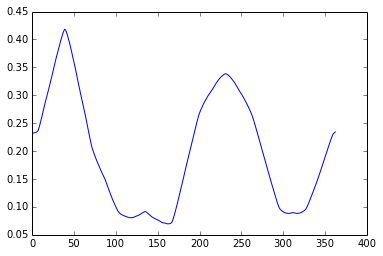

In [25]:
mask = r_array
time = [i for i in range(1,363)]
#for i in range(len(data)): 
plt.plot(time,data[1355])
plt.savefig("/home/faizan/Desktop/EVI.png")
plt.show()

In [24]:
plt.savefig("/home/faizan/Desktop/EVI.png")

In [ ]:
plt.figure(figsize=(20, 14))
for clu in xrange(7,8):
    centroids=k_means_clust(data,clu,6,5)
    Leg=[]
    n=0
    for i in centroids:
        #plt.subplot(2,3,clu-1)
        plt.subplot(1,1,1)
        plt.plot(i)
        Leg.append(str(n))
        n +=1
    plt.legend(Leg, loc='upper right', labelspacing=.2, prop={'size':10})
plt.savefig("/home/faizan/Desktop/classidica_lar.png")
plt.show()

In [ ]:
np.save("/home/faizan/Desktop/centroids_lar", centroids)

In [ ]:
ARRAY = np.load("/home/faizan/Desktop/centroids_lar.npy")

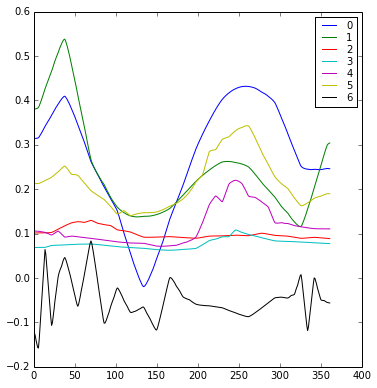

In [108]:
plt.figure(figsize=(20, 14))
Leg=[]
n=0
for i in centroids:
    plt.subplot(2,3,clu-1)
    plt.plot(i)
    Leg.append(str(n))
    n +=1
plt.legend(Leg, loc='upper right', labelspacing=.2, prop={'size':10})
plt.show()

# assigning cluster number to each pixel

In [ ]:

def find_clust(data,cluster,w=5):
    centroids=cluster
    counter=0
    assignments={}
    #assign data points to clusters
    for ind,i in enumerate(data):
        min_dist=float('inf')
        closest_clust=None
        for c_ind,j in enumerate(centroids):
            if LB_Keogh(i,j,5)<min_dist:
                cur_dist=DTWDistance(i,j,w)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_clust=c_ind
        if closest_clust in assignments:
            assignments[closest_clust].append(ind)
        else:
            assignments[closest_clust]=[ind]
    return assignments

In [ ]:
def assign_clust(data,assignments):
    classify = [0 for i in data]
    for key in assignments:
        for k in assignments[key]:
            classify[k]= key
    return classify

In [ ]:
def classification(mask,classify):
    array=[255 for i in mask.flatten()]
    n=0
    for d in np.where(mask.flatten() == 1)[0]:
        array[d]=(classify[n])
        n +=1
    return np.asarray(array)


In [ ]:
assignments= find_clust(data,centroids,5)
classify=assign_clust(data,assignments)
array=classification(mask,classify)

In [ ]:
assignments

In [ ]:
len(classify) 

In [ ]:
image = GImage(path)
image.Array2Tiff(out_name="/home/faizan/Desktop/classification_lar.tif", Array=array)

In [ ]:
Mask=mask.flatten()
image.Array2Tiff(out_name="/home/faizan/Desktop/mask_lar.tif", Array=Mask)

In [3]:
clusters= np.load("/home/faizan/Desktop/centroids_pak_kharif.npy")

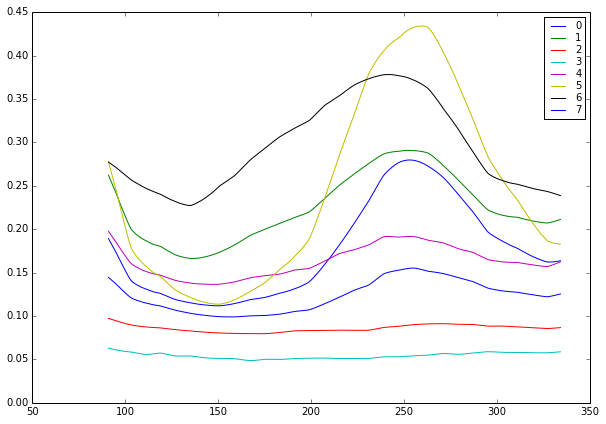

In [8]:
plt.figure(figsize=(10, 7))
Leg=[]
n=0
time = [i for i in range(91,335)]
for i in clusters:
    plt.plot(time, i)
    Leg.append(str(n))
    n +=1
plt.legend(Leg, loc='upper right', labelspacing=.2, prop={'size':10})
plt.savefig("/home/faizan/Desktop/Kharif_dtw.png")
plt.show()



In [50]:
for i in range(len(data)):
    minn= min(data[i])
    print minn

0.0606
0.0761
0.0631
0.1851
0.0938
0.0494
0.0847
0.0527
0.1486
0.0904
0.0568
0.0871
0.0756
0.1218
0.0658
0.0558
0.0954
0.0834
0.1129
0.1527
0.0681
0.0305
0.0701
-0.0201
0.112
0.1024
0.0563
0.0719
0.0879
0.091
0.1477
0.122
0.0603
0.0673
0.0737
0.0617
0.0847
0.0959
0.1244
0.0686
0.0732
-0.1578
-0.0188
0.0735
0.0861
0.0641
0.0758
0.0482


In [56]:
year = 2009
mask =r_array
files = ["/home/faizan/Pakistan/EVI/"+str(year)+"/Larkana.%d%03d"  % (year, i) + ".tif" for i in range(1, 363) ]
mimage = MultiImages(files)
AllArrays = mimage.Images2Arrays()
results = [0 for i in AllArrays[0]]
for i in np.where(mask.flatten() == 1)[0]:
    array = AllArrays.T[i]
    results[i] = array

In [54]:
results = [0 for i in AllArrays[0]]

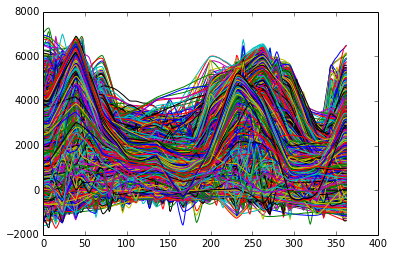

In [59]:
time = [i for i in range(1,363)]
for i in np.where(mask.flatten() == 1)[0]: 
    plt.plot(time,results[i])
plt.show()

In [6]:
EVI_path= "/home/faizan/HDD1/EVI/CSV/Pak_crop_all_point_evi.csv"
data1 = pd.read_csv(EVI_path)
for p in range(49):

    data = data1[data1["ID"] == p]
    dates = [datetime.datetime.strptime(str(k), "%Y%j") for k in data["DATE"]]
    data.index = dates
    dummy = data[data.index.year > 2008]
    dummy = dummy[dummy.index.year < 2010]
    #dummy = dummy[dummy.index.month > 5]
    time = dummy.index
    evi  = dummy["EVI"]
    time1=dummy["DATE"]
    if p==0:
        comb=evi
    else:
        comb=np.vstack((comb, evi))
    

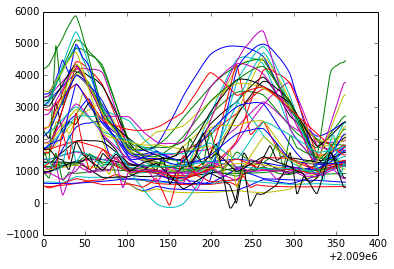

In [8]:
for i in range(49):  
    plt.plot(time1,comb[i])
plt.show()


10
10
10
10
10
10


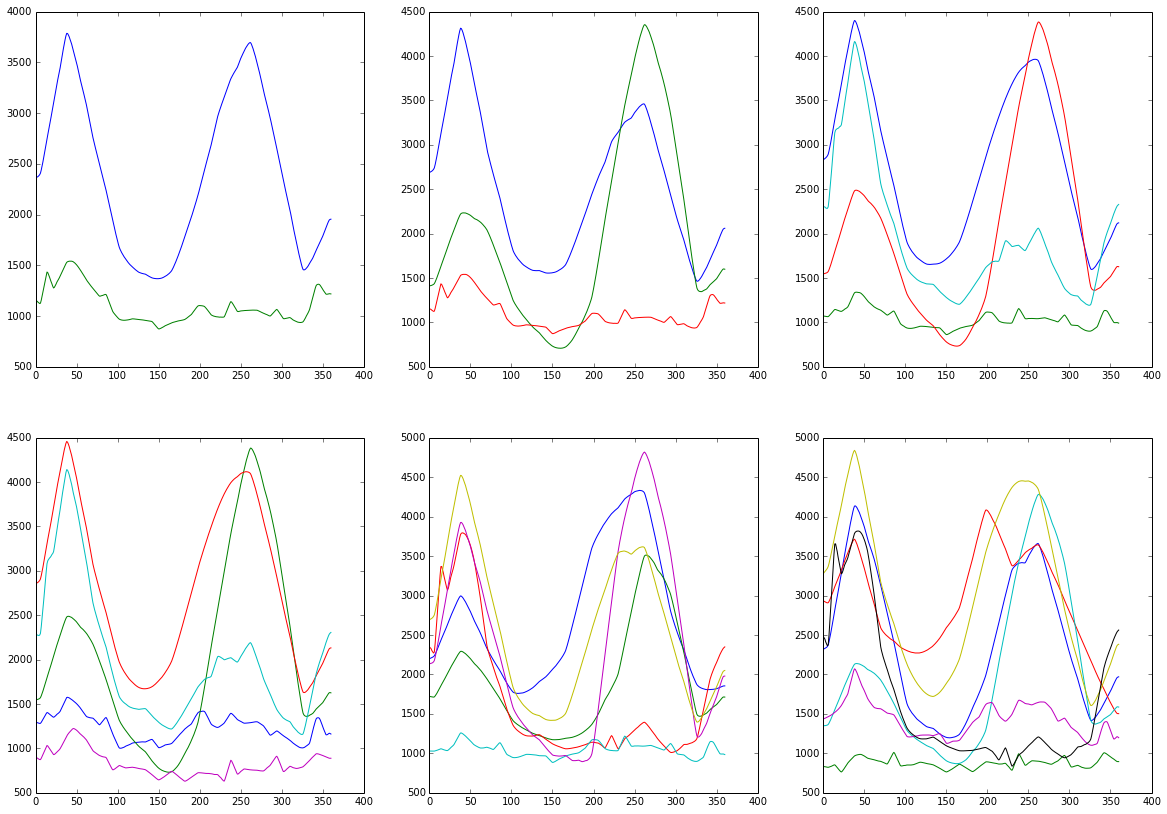

In [21]:
#train = np.genfromtxt('datasets/train.csv', delimiter='\t')
#test = np.genfromtxt('datasets/test.csv', delimiter='\t')

plt.figure(figsize=(20, 14))

for clu in xrange(2,8):
    centroids=k_means_clust(comb,clu,10,5)
    for i in centroids:
            plt.subplot(2,3,clu-1)
            plt.plot(i)
plt.show()

In [19]:
plt.savefig("/home/faizan/Desktop/clustering1.png")


In [256]:
centroids=random.sample(comb,6)
for c_ind,j in enumerate(centroids):
    #print j
    print c_ind

0
1
2
3
4
5


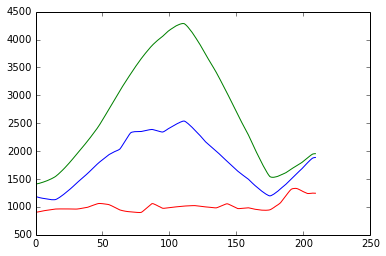

In [234]:
centroids=k_means_clust(comb,3,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

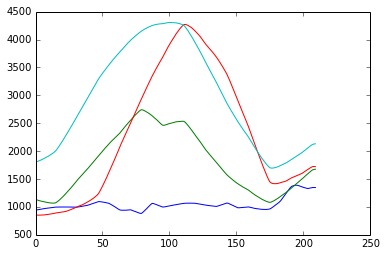

In [228]:
centroids=k_means_clust(comb,4,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

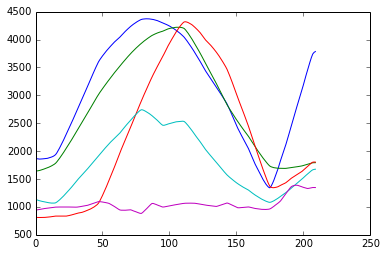

In [229]:
centroids=k_means_clust(comb,5,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

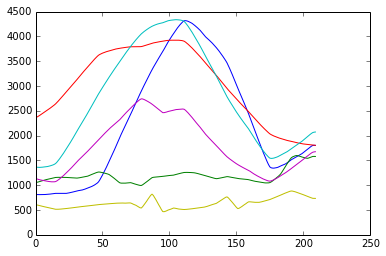

In [230]:
centroids=k_means_clust(comb,6,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

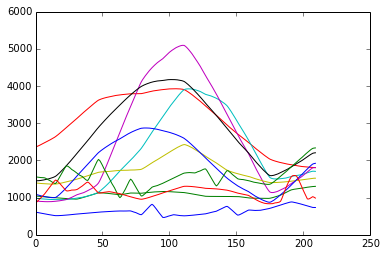

In [231]:
centroids=k_means_clust(comb,10,10,5)
for i in centroids:    
    plt.plot(i)
plt.show()

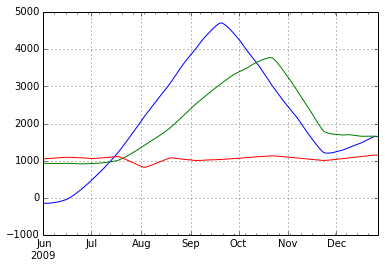

In [168]:
evi.plot()
evi2.plot()
evi3.plot()

In [7]:
train = np.genfromtxt('/home/faizan/Desktop/te.csv', delimiter='\t')

In [8]:
data=np.vstack((train[:,:-1],train[:,:-1]))

In [9]:
data

array([[-1.4139728 , -1.1620647 , -0.62417387, ...,  1.3630718 ,
         0.72553966, -0.88008903],
       [-1.115918  ,  0.23716141,  1.6308144 , ..., -1.3665346 ,
        -0.66266115, -1.2489139 ],
       [-1.2857446 , -0.06746462, -0.55532233, ..., -1.6829035 ,
         0.89153789,  1.5520388 ],
       ..., 
       [-0.10808234, -0.97877163, -0.55061271, ...,  0.78514926,
         0.36594352,  0.8416499 ],
       [-0.63008704, -0.5506395 ,  0.58111432, ..., -0.49145736,
        -0.96981644, -0.49904942],
       [ 0.81303753,  0.01441759,  1.2853706 , ...,  0.93264908,
         0.15278736, -0.03264544]])

10


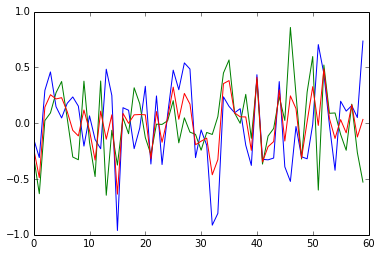

In [14]:
centroids=k_means_clust(data,3,10,5)
for i in centroids:
    
    plt.plot(i)

plt.show()